In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from xgboost import plot_importance


%matplotlib inline

# EDA

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [88]:
df = pd.read_csv("/content/drive/MyDrive/YSAL/2023-1/LOL/CL15_last_fix.csv")
df

,blueWins,blueTotalGolds,blueTotalLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueTotalDamageToChampion,blueFirstBlood,blueKill,blueDeath,blueAssist,...,blueAIR_DRAGON,blueEARTH_DRAGON,blueCHEMTECH_DRAGON,blueHEXTECH_DRAGON,redWATER_DRAGON,redFIRE_DRAGON,redAIR_DRAGON,redEARTH_DRAGON,redCHEMTECH_DRAGON,redHEXTECH_DRAGON
0,1,68345,68,821,234,133185,1,34,36,80,...,1,0,1,0,0,0,0,0,1,0
1,1,45134,59,572,152,82355,0,30,17,39,...,1,0,1,1,0,0,0,0,0,0
2,1,59883,67,672,234,112250,1,34,30,89,...,0,1,0,0,0,1,0,0,0,1
3,0,28396,45,445,101,32956,1,9,19,13,...,0,0,0,0,0,0,0,0,0,1
4,0,57451,67,741,157,102647,1,39,37,51,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,1,44325,54,563,165,60656,1,28,13,40,...,0,0,0,1,1,0,0,0,0,0
1517,0,33987,46,485,99,44699,1,24,25,31,...,0,0,0,1,0,1,0,0,1,0
1518,1,42094,50,454,98,79347,1,36,14,61,...,0,0,1,0,0,0,0,0,0,1
1519,1,29957,43,412,102,37715,1,22,6,30,...,0,0,1,0,0,0,0,0,0,0


In [73]:
# 필요없는 칼럼 drop
# drop_df = df.drop(['Unnamed: 0', 'gameId','redWins',
#                    "blueFirstTowerLane",'blueDragonType','redFirstTowerLane','redDragonType'], axis=1)
# drop_df

In [74]:
# dragon count 
drop_df["blueDragonCount"] = drop_df.filter(regex='(?=(.*blue.*))(?=(.*DRAGON.*)).*').sum(axis=1)
drop_df["redDragonCount"] = drop_df.filter(regex='(?=(.*red.*))(?=(.*DRAGON.*)).*').sum(axis=1)


# *DRAGON drop
drop_df = drop_df[drop_df.columns.drop(list(drop_df.filter(regex="(.*_DRAGON.*)")))]


<Axes: >

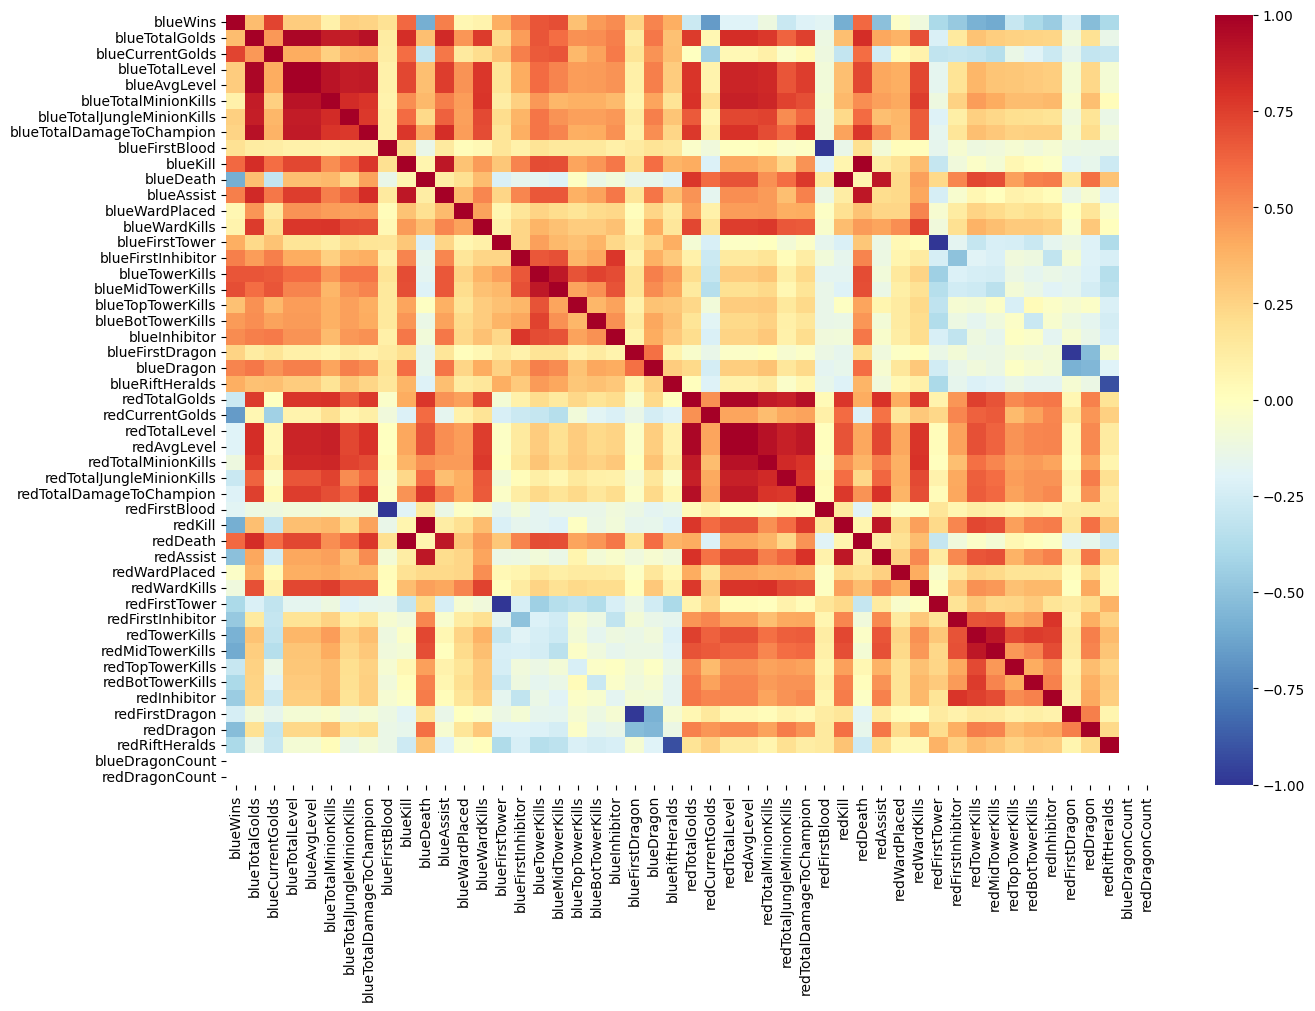

In [75]:
corr_df = drop_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr_df, 
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [76]:
# 승패 여부와 상관관계 top 10 변수들
np.abs(corr_df["blueWins"][1:]).sort_values(ascending=False).head(10)

blueCurrentGolds     0.732447
blueMidTowerKills    0.702084
blueTowerKills       0.676278
redCurrentGolds      0.661298
redDeath             0.612390
blueKill             0.612390
redMidTowerKills     0.603785
redKill              0.586535
blueDeath            0.586535
redTowerKills        0.572385
Name: blueWins, dtype: float64

# 모델링

In [83]:
# drop_df = df.drop(['Unnamed: 0', 'gameId','redWins',
#                    "blueFirstTowerLane",'blueDragonType','redFirstTowerLane','redDragonType'], axis=1)
# drop_df
df = pd.read_csv("/content/drive/MyDrive/YSAL/2023-1/LOL/CL15_last_fix.csv")

In [84]:
df.dtypes.unique()

array([dtype('int64')], dtype=object)

In [85]:
def train_test(df):
  y_train = df['blueWins']
  x_train = df.drop(['blueWins'], axis=1)
  return x_train, y_train

In [89]:
x_train, y_train = train_test(df)

val_size=0.3

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = val_size, random_state=42)

In [91]:
x_train.columns

Index(['blueTotalGolds', 'blueTotalLevel', 'blueTotalMinionKills',
       'blueTotalJungleMinionKills', 'blueTotalDamageToChampion',
       'blueFirstBlood', 'blueKill', 'blueDeath', 'blueAssist',
       'blueWardPlaced', 'blueWardKills', 'blueFirstTower',
       'blueFirstInhibitor', 'blueTowerKills', 'blueMidTowerKills',
       'blueTopTowerKills', 'blueBotTowerKills', 'blueInhibitor',
       'blueFirstDragon', 'blueDragon', 'blueRiftHeralds', 'redTotalGolds',
       'redTotalLevel', 'redTotalMinionKills', 'redTotalJungleMinionKills',
       'redTotalDamageToChampion', 'redFirstBlood', 'redKill', 'redDeath',
       'redAssist', 'redWardPlaced', 'redWardKills', 'redFirstTower',
       'redFirstInhibitor', 'redTowerKills', 'redMidTowerKills',
       'redTopTowerKills', 'redBotTowerKills', 'redInhibitor',
       'redFirstDragon', 'redDragon', 'redRiftHeralds', 'blueWATER_DRAGON',
       'blueFIRE_DRAGON', 'blueAIR_DRAGON', 'blueEARTH_DRAGON',
       'blueCHEMTECH_DRAGON', 'blueHEXTECH_D

Index(['blueTotalGolds', 'blueCurrentGolds', 'blueTotalLevel', 'blueAvgLevel',
       'blueTotalMinionKills', 'blueTotalJungleMinionKills',
       'blueTotalDamageToChampion', 'blueFirstBlood', 'blueKill', 'blueDeath',
       'blueAssist', 'blueWardPlaced', 'blueWardKills', 'blueFirstTower',
       'blueFirstInhibitor', 'blueTowerKills', 'blueMidTowerKills',
       'blueTopTowerKills', 'blueBotTowerKills', 'blueInhibitor',
       'blueFirstDragon', 'blueDragon', 'blueRiftHeralds', 'redTotalGolds',
       'redCurrentGolds', 'redTotalLevel', 'redAvgLevel',
       'redTotalMinionKills', 'redTotalJungleMinionKills',
       'redTotalDamageToChampion', 'redFirstBlood', 'redKill', 'redDeath',
       'redAssist', 'redWardPlaced', 'redWardKills', 'redFirstTower',
       'redFirstInhibitor', 'redTowerKills', 'redMidTowerKills',
       'redTopTowerKills', 'redBotTowerKills', 'redInhibitor',
       'redFirstDragon', 'redDragon', 'redRiftHeralds', 'blueWATER_DRAGON',
       'blueFIRE_DRAGON', 'blue

## Xgboost

파라미터 튜닝

In [82]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
from bayes_opt import BayesianOptimization

In [57]:
# 탐색 대상 함수 (XGBRegressor)
def XGB_cv(max_depth,learning_rate, n_estimators, gamma
            ,min_child_weight, subsample
            ,colsample_bytree, silent=True, nthread=-1):

    # 모델 정의
    model = xgb.XGBClassifier(max_depth=int(max_depth),
                            learning_rate=learning_rate,
                            n_estimators=int(n_estimators),
                            gamma=gamma,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree, 
                            nthread=nthread
                            )
    # 모델 훈련
    model.fit(x_train, y_train)

    # 예측값 출력
    y_pred= model.predict(x_valid)

    return f1_score(y_valid, y_pred)

In [58]:
pbounds = {'max_depth': (3, 7),
                'learning_rate': (0.01, 0.3),
                'n_estimators': (20,100),
                'gamma': (0, 100),
                'min_child_weight': (0, 3),
                'subsample': (0.5, 1),
                'colsample_bytree' :(0.2, 1)
                }

bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    

bo.maximize(init_points=2, n_iter=100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9349    | 0.5336    | 72.03     | 0.01003   | 4.209     | 0.4403    | 27.39     | 0.5931    |
| 2         | 0.9901    | 0.4764    | 39.68     | 0.1663    | 4.677     | 2.056     | 36.36     | 0.9391    |
| 3         | 0.9755    | 0.2046    | 40.19     | 0.1041    | 3.836     | 2.294     | 37.26     | 0.6836    |
| 4         | 0.9851    | 1.0       | 38.46     | 0.3       | 6.659     | 1.495     | 34.23     | 1.0       |
| 5         | 0.9851    | 1.0       | 37.03     | 0.3       | 6.431     | 0.0       | 38.0      | 1.0       |
| 6         | 0.9779    | 0.3418    | 35.94     | 0.2329    | 3.393     | 1.587     | 35.46     | 0.5161    |
| 7         | 0.9657    | 0.6233    | 42.25     | 0.0305    | 4.247     | 0.5601    | 32.74     | 0.8253    |
| 8       

## Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier


In [64]:
def bo_params_rf(max_samples,n_estimators,max_features, max_depth):
    
    params = {
        'max_samples': max_samples,
        'max_features':max_features,
        'max_depth':int(max_depth),
        'n_estimators':int(n_estimators)
    }
    clf = RandomForestClassifier(**params)
    
    clf.fit(x_train, y_train)

    # 예측값 출력
    y_pred= clf.predict(x_valid)

    return f1_score(y_valid, y_pred)

In [65]:
pbounds = {'max_samples':(0.5,1),
        'max_features':(0.5,1),
        'max_depth' : (3, 7),
        'n_estimators':(10,200)}

rf_bo = BayesianOptimization(bo_params_rf, pbounds=pbounds, verbose=2, random_state=1)
rf_bo.maximize(init_points=2, n_iter=100)

|   iter    |  target   | max_depth | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9776    | 4.668     | 0.8602    | 0.5001    | 67.44     |
| 2         | 0.9826    | 3.587     | 0.5462    | 0.5931    | 75.66     |
| 3         | 0.9774    | 3.883     | 0.6515    | 0.6017    | 75.83     |
| 4         | 0.9776    | 4.77      | 0.7067    | 0.7739    | 151.4     |
| 5         | 0.9825    | 5.494     | 0.6116    | 0.9795    | 162.9     |
| 6         | 0.96      | 3.085     | 0.9039    | 0.9824    | 143.4     |
| 7         | 0.9648    | 3.203     | 0.9004    | 0.6035    | 74.92     |
| 8         | 0.9875    | 5.341     | 0.6152    | 0.9048    | 162.8     |
| 9         | 0.9875    | 4.939     | 0.5179    | 0.9016    | 162.8     |
| 10        | 0.9774    | 4.3       | 0.8179    | 0.7003    | 152.8     |
| 11        | 0.9751    | 5.13      | 0.8188    | 0.5       | 162.7     |
| 12        | 0.9875    | 4.93      | 

In [66]:
print(bo.max)
print(rf_bo.max)

{'target': 0.9950248756218906, 'params': {'colsample_bytree': 0.3597553701363947, 'gamma': 8.004697583309294, 'learning_rate': 0.09656194317192385, 'max_depth': 6.235017335898533, 'min_child_weight': 0.36043801517314633, 'n_estimators': 63.20242456432359, 'subsample': 0.6529927234836326}}
{'target': 0.9925187032418954, 'params': {'max_depth': 6.630016480145736, 'max_features': 0.5352222863542987, 'max_samples': 0.6677225972822789, 'n_estimators': 69.03463745634791}}


## 최종 모델

Xgboost

In [94]:
xgb_params = {'colsample_bytree': 0.7399756367368562, 'gamma': 23.60157571112307, 'learning_rate': 0.1641944292221702, 
          'max_depth': 6, 'min_child_weight': 1.3577908241933232, 'n_estimators': 36, 'subsample': 0.8954956520260448}

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7399756367368562, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=23.60157571112307, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1641944292221702, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1.3577908241933232, missing=nan,
              monotone_constraints=None, n_estimators=36, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

RF

In [95]:
rf_params = {'max_depth': 5, 'max_features': 0.5152282117692119, 
          'max_samples': 0.6447967093611578, 'n_estimators': 133}
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.5152282117692119,
                       max_samples=0.6447967093611578, n_estimators=133)

# 다른 데이터에 적용

In [115]:
cl10 = pd.read_csv("/content/drive/MyDrive/YSAL/2023-1/LOL/CL10_fix.csv")
cl15 = pd.read_csv("/content/drive/MyDrive/YSAL/2023-1/LOL/CL15_fix.csv")

In [116]:
x_cl10 = cl10.drop("blueWins", axis=1)
y_cl10 = cl10["blueWins"]
x_cl15 = cl15.drop("blueWins", axis=1)
y_cl15 = cl15

In [117]:
x_cl10

,blueTotalGolds,blueTotalLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueTotalDamageToChampion,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,...,blueAIR_DRAGON,blueEARTH_DRAGON,blueCHEMTECH_DRAGON,blueHEXTECH_DRAGON,redWATER_DRAGON,redFIRE_DRAGON,redAIR_DRAGON,redEARTH_DRAGON,redCHEMTECH_DRAGON,redHEXTECH_DRAGON
0,12794,27,175,64,13135,1,6,7,11,15,...,0,0,0,0,0,0,0,0,0,0
1,13539,27,210,58,8545,0,5,3,7,16,...,1,0,0,0,0,0,0,0,0,0
2,13780,27,190,46,12009,0,8,3,10,13,...,1,0,0,0,0,0,0,0,0,0
3,12664,27,204,48,15293,0,4,8,5,22,...,0,0,0,0,0,0,0,0,0,0
4,11478,26,193,52,9808,0,3,6,3,15,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,14948,27,211,52,13230,1,8,6,14,27,...,0,0,0,0,0,0,0,0,0,0
1518,14636,27,207,60,13235,0,8,6,12,31,...,0,0,0,0,0,0,0,0,0,0
1519,10799,24,164,48,4895,0,2,10,1,9,...,0,0,0,0,0,0,0,1,0,0
1520,11688,27,199,40,10698,0,3,3,5,23,...,0,0,0,0,0,0,0,0,0,0


## Cl_10

xgboost

In [125]:
y_pred = xgb_model.predict(x_cl10)
print("F1 score: ", f1_score(y_cl10, y_pred))
print("Accuracy: %.2f%%" % (accuracy_score(y_cl10, y_pred) * 100.0))

F1 score:  0.13910761154855641
Accuracy: 56.90%


Rf

In [127]:
y_pred = rf_model.predict(x_cl10)
print("F1 sore: ", f1_score(y_cl10,y_pred)  )
print("Accuracy: %.2f%%" % (accuracy_score(y_cl10, y_pred) * 100.0))

F1 sore:  0.4137931034482759
Accuracy: 63.14%
